# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import lightgbm as lgb
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_transformer, 
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor, log_evaluation
from sklearn.dummy import DummyRegressor
plt.rcParams["figure.figsize"] = (7,9)
pd.options.mode.chained_assignment = None

### Изучим данные

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Сразу в нескольких столбцах присутствуют пропущенные значения.

In [6]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Сразу заметны аномальные значения в столбце с мощностью автомобилей, годом регистрации.

### Предобработка данных

Для начала, приведем все названия столбцов к нижнему регистру и придадим им правильный вид.

In [7]:
data.columns = data.columns.str.lower()
data.rename(columns = {'datecrawled':'date_crawled', 
                     'vehicletype':'vehicle_type',
                    'registrationyear': 'registration_year',
                    'registrationmonth': 'registration_month',
                    'fueltype': 'fuel_type',
                    'datecreated': 'date_created',
                    'numberofpictures': 'number_of_pictures',
                    'postalcode': 'postal_code',
                    'lastseen': 'last_seen'}, inplace = True )
data.head(10)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


Теперь избавимся от аномальных значений в столбцах.

Сначала рассмотрим столбец `price`.

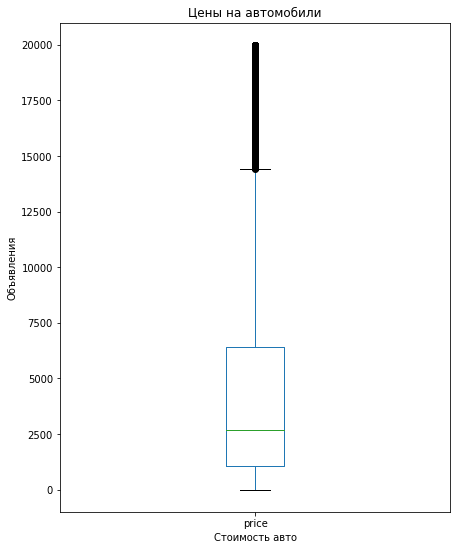

In [8]:
data['price'].plot.box();
plt.title('Цены на автомобили');
plt.xlabel('Стоимость авто');
plt.ylabel('Объявления');

По цене автомобили, тем более новые, могут продаваться за высокую цену. Ранее мы узнали, что в столбце есть значения = 0. Это аномально низкое значение, машину не могут отдавать бесплатно (а если и могут, то это единичные случаи). Удалим значения ниже 100 для данного столбца, чтобы отсеять черезчур щедрых продавцов .

In [9]:
data[data.index==7]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58


In [10]:
data['price'] = data['price'].replace(range(0, 100), np.nan)

In [11]:
data[data.index==7]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,NaN,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58


In [12]:
data['price'].isna().sum()

13314

In [13]:
data = data.dropna(subset=['price'])

Далее столбец `registration_year`.

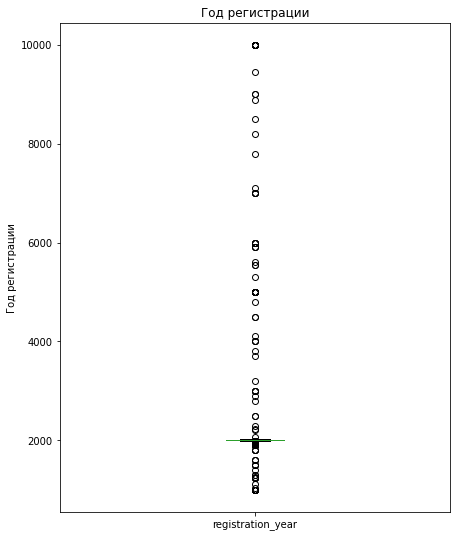

In [14]:
data['registration_year'].plot.box();
plt.title('Год регистрации');
plt.ylabel('Год регистрации');

In [15]:
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 1910, 2016,
       2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994, 1991,
       1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985, 1989,
       2015, 1982, 1976, 1983, 1973, 1969, 1971, 1987, 1986, 1988, 1980,
       1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968, 1977,
       1961, 1966, 1975, 1963, 1964, 1960, 1958, 1967, 1956, 3200, 1000,
       1941, 9999, 8888, 1500, 2200, 4100, 1962, 1929, 1957, 1940, 3000,
       2066, 1949, 2019, 1937, 1951, 1800, 1959, 1953, 1954, 1234, 5300,
       9000, 2900, 6000, 5900, 5911, 1400, 5000, 1950, 4000, 1948, 1952,
       8500, 1932, 1255, 3700, 3800, 4800, 1942, 7000, 1935, 1933, 1936,
       1923, 2290, 1930, 1001, 9450, 1944, 2500, 1943, 1938, 1934, 1928,
       5555, 5600, 1600, 1111, 2222, 1039, 1300, 2800, 1931, 4500, 1602,
       7800, 1947, 1927, 7100, 8200, 1946])

В данном столбце очень много аномальных значений с огромным разбросом. Избавимся от данных объявлений, так как заполнить какими-либо значениями не представляется возможным.

In [16]:
data = data.query('registration_year > 1987 and  registration_year <= 2016')
data['registration_year'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 2014, 1998, 2005, 2016, 2007,
       2009, 2002, 1997, 1990, 2003, 1994, 1991, 2006, 1999, 2012, 2010,
       2000, 1992, 2013, 1996, 1989, 2015, 1988])

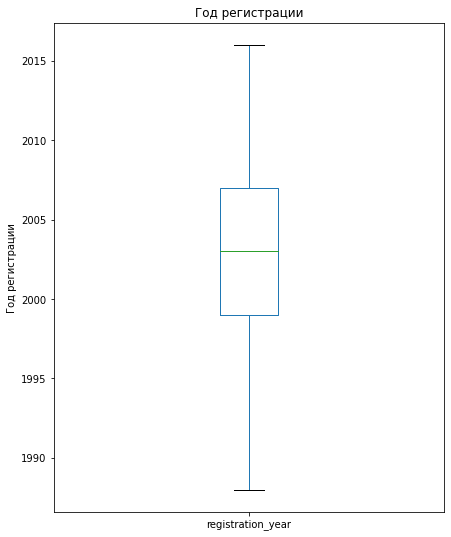

In [17]:
data['registration_year'].plot.box();
plt.title('Год регистрации');
plt.ylabel('Год регистрации');

Выглядит отлично!

Теперь рассмотрим столбец `power`.

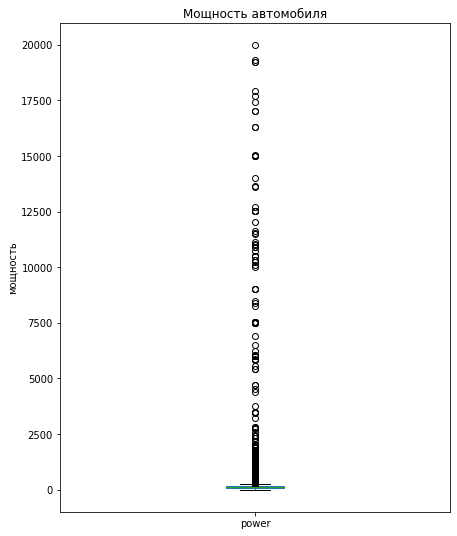

In [18]:
data['power'].plot.box();
plt.title('Мощность автомобиля');
plt.ylabel('мощность');

In [19]:
def scatter (column, yname, title):
    
    plt.plot(data['power'], data[column].astype(str), 'o')

    plt.xlabel('Мощность автомобиля')
    plt.ylabel(yname)
    plt.title(title);

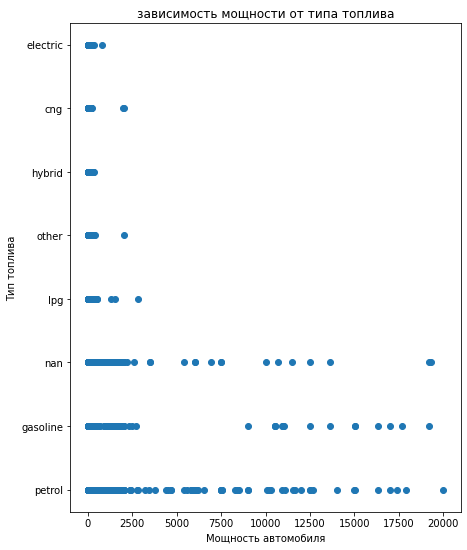

In [20]:
scatter ('fuel_type', 'Тип топлива', 'зависимость мощности от типа топлива')

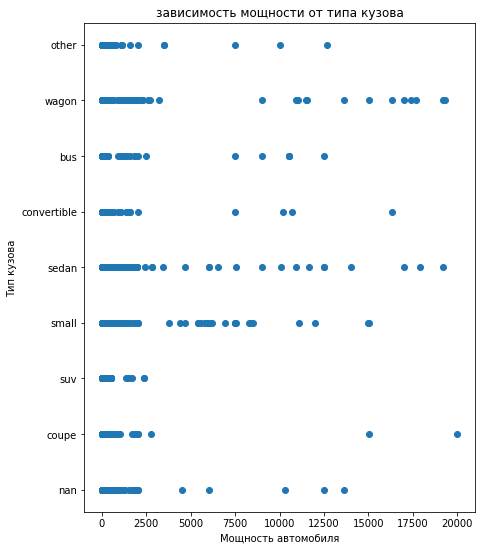

In [21]:
scatter ('vehicle_type', 'Тип кузова', 'зависимость мощности от типа кузова')

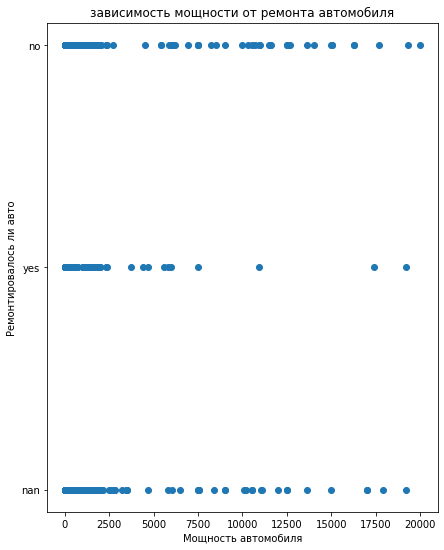

In [22]:
scatter ('repaired', 'Ремонтировалось ли авто', 'зависимость мощности от ремонта автомобиля')

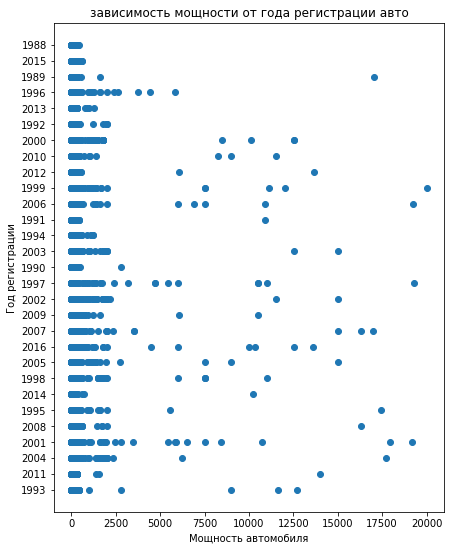

In [23]:
scatter ('registration_year', 'Год регистрации', 'зависимость мощности от года регистрации авто')

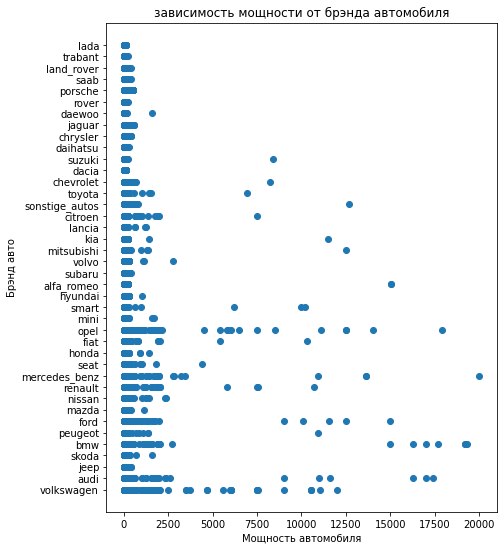

In [24]:
scatter ('brand', 'Брэнд авто', 'зависимость мощности от брэнда автомобиля')

Нельзя сказать, что данный параметр сильно зависит от другого. Удалим все невалидные наблюдения.

In [25]:
Low = data['power'].quantile(0.1)
High = data['power'].quantile(0.75)
data = data[data['power'] >= Low]
data = data[data['power'] <= High]

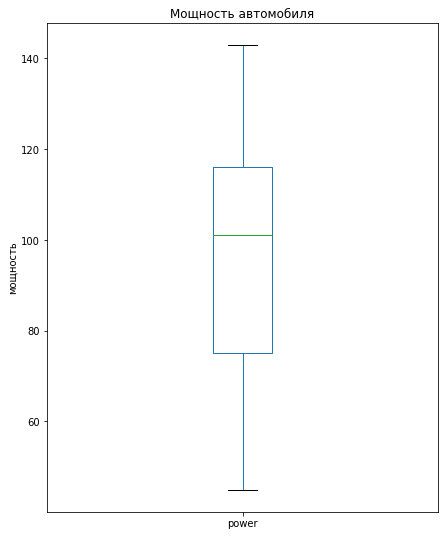

In [26]:
data['power'].plot.box();
plt.title('Мощность автомобиля');
plt.ylabel('мощность');

Хотелось бы понять, от каких столбцов нам следует избавиться для дальнейшей работы.

Поставленная задача - быстро узнать рыночную стоимость своего автомобиля автовладельцем. Не факт, что все признаки будут влиять на стоимость авто. Например, столбцы с датами и время последней активности пользователя для нас не играют никакой роли.

А также количество фото и почтовый индекс пользователя.

In [27]:
data = data.drop(['date_crawled', 'date_created', 'registration_month', 'last_seen', 'number_of_pictures', 'postal_code'], axis=1)

Узнаем в каких столбцах есть пропуски. 

In [28]:
data.isna().sum() 

price                    0
vehicle_type          8781
registration_year        0
gearbox               4132
power                    0
model                 7307
kilometer                0
fuel_type            11592
brand                    0
repaired             31984
dtype: int64

Проверим, от чего сильнее всего зависит стоимость авто на рынке.

In [29]:
def scatter (column, yname, title):
    
    plt.plot(data['price'], data[column].astype(str), 'o')

    plt.xlabel('Стоимость авто')
    plt.ylabel(yname)
    plt.title(title);

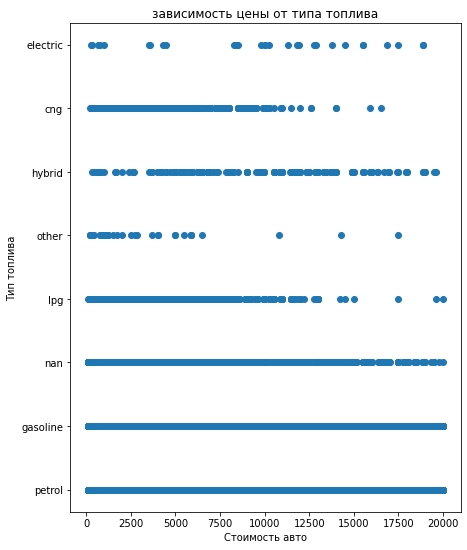

In [30]:
scatter ('fuel_type', 'Тип топлива', 'зависимость цены от типа топлива')

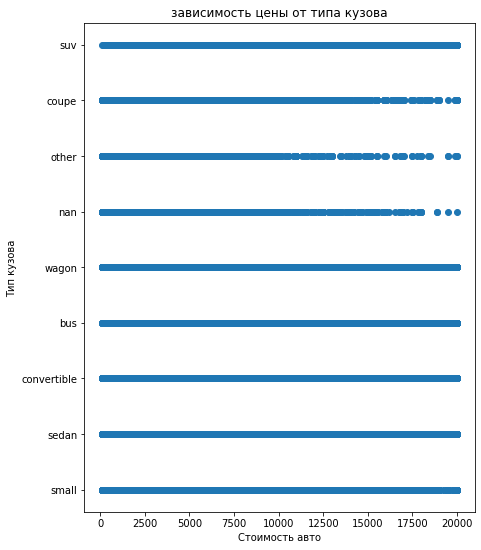

In [31]:
scatter ('vehicle_type', 'Тип кузова', 'зависимость цены от типа кузова')

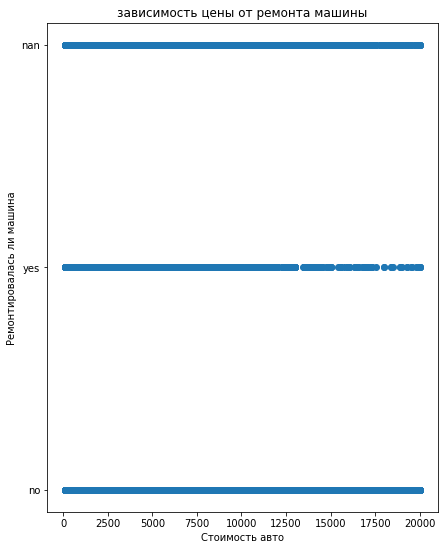

In [32]:
scatter ('repaired', 'Ремонтировалась ли машина', 'зависимость цены от ремонта машины')

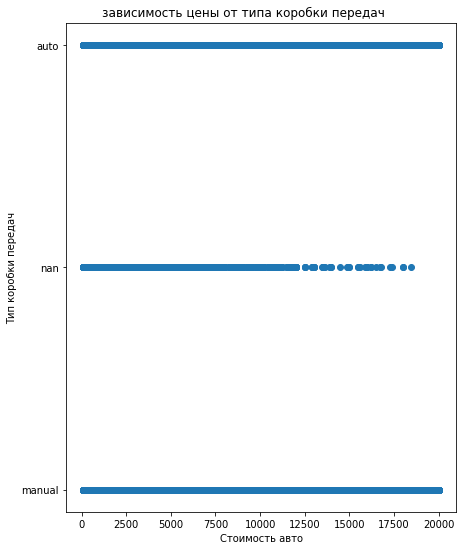

In [33]:
scatter ('gearbox', 'Тип коробки передач', 'зависимость цены от типа коробки передач         ')

Явной зависимости не наблюдается.

К сожалению, мы не можем заменить значения в этих столбцах на какие-либо, так как это исказит данные. Придется избавиться от пропусков, заменив их заглушкой . 

Также столбец `model` заполнить мы тоже не можем, моделей очень большое количество и нельзя угадать ту самую.

In [34]:
data = data.fillna('unknown')

In [35]:
data.isna().sum() 

price                0
vehicle_type         0
registration_year    0
gearbox              0
power                0
model                0
kilometer            0
fuel_type            0
brand                0
repaired             0
dtype: int64

Теперь, когда мы имеем данные без пропусков в них, еще раз проверим на аномальные значения и избавимся от оставшихся.

In [36]:
data.reset_index(drop= True , inplace= True )
data

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,1500.0,small,2001,manual,75,golf,150000,petrol,volkswagen,no
1,3600.0,small,2008,manual,69,fabia,90000,gasoline,skoda,no
2,650.0,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
3,2200.0,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
4,14500.0,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
...,...,...,...,...,...,...,...,...,...,...
210578,1490.0,small,1998,manual,50,lupo,150000,petrol,volkswagen,no
210579,7900.0,sedan,2010,manual,140,golf,150000,gasoline,volkswagen,no
210580,1199.0,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
210581,9200.0,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


In [37]:
def visual (column, xname, bins, title):          
    sns.histplot(data=data[column], bins=bins);
    plt.xlabel(xname);
    plt.ylabel('Количество объявлений');
    plt.title(title)
    plt.show()      

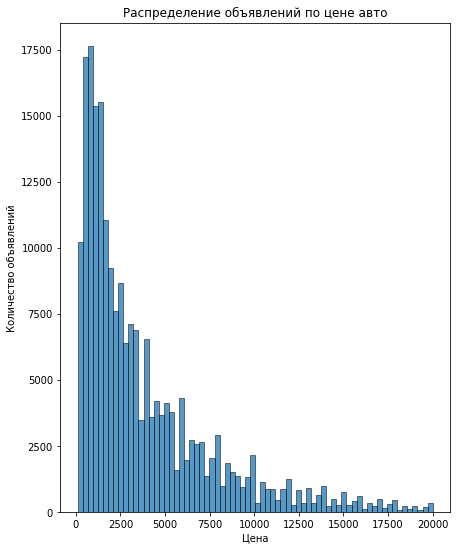

In [38]:
visual ('price', 'Цена', 70, 'Распределение объявлений по цене авто')  

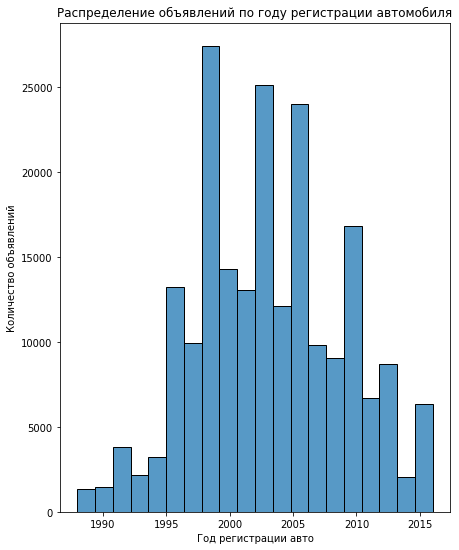

In [39]:
visual ('registration_year', 'Год регистрации авто', 20, 'Распределение объявлений по году регистрации автомобиля')  

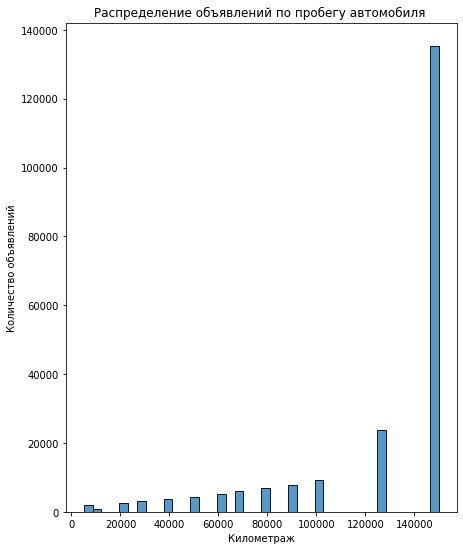

In [40]:
visual ('kilometer', 'Километраж', 40, 'Распределение объявлений по пробегу автомобиля ')

Так как основная масса автомобилей с пробегом, такой показатель - норма.

Все показатели без явных выбросов, пропуски заполнены, где это было возможно, остальные данные очищены.

**Разделим выборку на признаки и целевую переменную**. 

In [42]:
# Разделение на признаки (X) и целевую переменную (y)

X = data.drop(columns=['price'], axis=1)
y = data['price']

In [43]:
# 2. Разделение данных на обучающую, валидационную и тестовую выборки

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X.shape)
print(y.shape)
print()
print('Размеры обучающей выборки:')
print(X_train.shape)
print(y_train.shape)
print()
print('Размеры тестовой выборки:')
print(X_test.shape)
print(y_test.shape)

(210583, 9)
(210583,)

Размеры обучающей выборки:
(168466, 9)
(168466,)

Размеры тестовой выборки:
(42117, 9)
(42117,)


## Обучение моделей

In [44]:
# создадим функцию, которая будет подбирать гиперпараметры для указанной ей модели
# затем данная функция будет проводить кросс-валидацию по метрике RMSE

def score(model_name, params, features, target):
    model = model_name
    parametrs = params    
    grid = GridSearchCV(model, parametrs, scoring='neg_mean_squared_error', cv=3) 
    grid.fit(features, target)    
    print('RMSE модели:', (-grid.best_score_)**0.5)
    print('лучшие параметры:', grid.best_estimator_)

Воспользуемся кодировкой данных для линейной регрессии с помощью `OneHotEncoder`.

In [45]:
X_train_ohe = X_train.copy()

In [46]:
# признак repaired уже бинарный, его не будем кодировать/масштабировать
# добавляем remainder='passthrough', чтобы он не пропал

X_features_ohe = X_train_ohe.select_dtypes(include='object').columns.to_list()
numeric_features = ['power', 'registration_year', 'kilometer']

col_transformer = make_column_transformer(
    (OneHotEncoder(drop='first', handle_unknown='ignore'), X_features_ohe),
    (StandardScaler(), numeric_features),
    remainder='passthrough',
    verbose_feature_names_out=False)

# всё готово в пару строк кода
X_train_ohe = pd.DataFrame.sparse.from_spmatrix(
    col_transformer.fit_transform(X_train_ohe),
    columns=col_transformer.get_feature_names_out())

In [47]:
# для начала рассмотрим модель линейной регрессии

score(LinearRegression(), {}, X_train_ohe, y_train)

RMSE модели: 1880.6536386710554
лучшие параметры: LinearRegression()


In [48]:
%%time
model = LinearRegression()
model.fit(X_train_ohe, y_train);

CPU times: user 9.01 s, sys: 17.4 s, total: 26.4 s
Wall time: 26.5 s


LinearRegression()

In [49]:
%%time
predicts = model.predict(X_train_ohe)

CPU times: user 62.3 ms, sys: 79.9 ms, total: 142 ms
Wall time: 202 ms


Результат подходит под требуемый: Значение метрики RMSE - 1880.
Время затраченное на обработку ячейки обучения: 26 секунд. Предсказание - 51 мсекунда.

И воспользуемся `OrdinalEncoder` для кодировки признаков для древесных моделей.

In [50]:
X_train_ordinal = X_train.copy()
X_test_ordinal = X_test.copy()

In [51]:
X_features_ordinal = X_train_ordinal.select_dtypes(include='object').columns.to_list() 
encoder_ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value = y.median().astype(int))

# обучаем энкодер на заданных категориальных признаках тренировочной выборки
encoder_ordinal.fit(X_train_ordinal[X_features_ordinal])

# кодируем тренировочную выборку
X_train_ordinal[encoder_ordinal.get_feature_names_out()] = encoder_ordinal.transform(X_train_ordinal[X_features_ordinal])

display(X_train_ordinal.head(5))

# обучаем энкодер на заданных категориальных признаках тестовой выборки
encoder_ordinal.fit(X_test_ordinal[X_features_ordinal])

# кодируем тестовую выборку
X_test_ordinal[encoder_ordinal.get_feature_names_out()] = encoder_ordinal.transform(X_test_ordinal[X_features_ordinal])

display(X_test_ordinal.head(5))

,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
158898,5.0,2010,1.0,69,119.0,100000,6.0,10.0,0.0
192037,5.0,2000,1.0,75,94.0,125000,6.0,10.0,0.0
136798,8.0,2002,1.0,131,161.0,150000,2.0,38.0,0.0
165492,5.0,2009,1.0,76,210.0,125000,6.0,27.0,0.0
155193,4.0,2004,1.0,85,107.0,150000,6.0,38.0,1.0


,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
29762,5.0,2004,1.0,63,101.0,150000,6.0,12.0,1.0
33343,8.0,2000,1.0,116,14.0,150000,4.0,19.0,0.0
71571,1.0,2005,1.0,109,7.0,125000,6.0,25.0,0.0
137734,8.0,2003,1.0,75,89.0,150000,6.0,30.0,1.0
198368,1.0,1998,1.0,110,140.0,150000,6.0,19.0,0.0


In [52]:
# Теперь модель дерева решений
score(DecisionTreeRegressor(random_state=12345),{'max_depth': range (1, 13, 2),
                               'min_samples_leaf': range (1, 11)}, 
                                X_train_ordinal, y_train)

RMSE модели: 1459.1305076115832
лучшие параметры: DecisionTreeRegressor(max_depth=11, min_samples_leaf=4, random_state=12345)


In [53]:
%%time

model = DecisionTreeRegressor(max_depth=11, min_samples_leaf=4, random_state=12345)
model.fit(X_train_ordinal, y_train)

CPU times: user 271 ms, sys: 0 ns, total: 271 ms
Wall time: 278 ms


DecisionTreeRegressor(max_depth=11, min_samples_leaf=4, random_state=12345)

In [54]:
%%time
predicts = model.predict(X_train_ordinal)

CPU times: user 23.7 ms, sys: 0 ns, total: 23.7 ms
Wall time: 26 ms


Результат подходит под требуемый: Значение метрики RMSE - 1459. Время затраченное на обработку ячейки обучения: 359 мсекунд. Предсказание - 23.2 мсекунды.

In [56]:
%%time 
# и случайный лес 

score(RandomForestRegressor(random_state=12345),{'max_depth': range (5, 10, 1),                          
                          'n_estimators': range (50, 100, 10)}, 
                           X_train_ordinal, y_train)

RMSE модели: 1468.8056458642786
лучшие параметры: RandomForestRegressor(max_depth=9, n_estimators=90, random_state=12345)
CPU times: user 7min 31s, sys: 0 ns, total: 7min 31s
Wall time: 7min 32s


In [57]:
%%time

model = RandomForestRegressor(max_depth=9, n_estimators=90, random_state=12345)
model.fit(X_train_ordinal, y_train)

CPU times: user 14 s, sys: 0 ns, total: 14 s
Wall time: 14 s


RandomForestRegressor(max_depth=9, n_estimators=90, random_state=12345)

In [58]:
%%time
predicts = model.predict(X_train_ordinal) 

CPU times: user 938 ms, sys: 0 ns, total: 938 ms
Wall time: 953 ms


Результат подходит под требуемый: Значение метрики RMSE - 1468 . Время затраченное на обработку ячейки обучения: 14 секунд. Предсказание - 1.15 секунды. 

Используем библиотеку LightGBM и её средствами построим модель градиентного бустинга.

In [59]:
score(LGBMRegressor(random_state=12345),{'n_estimators': range (50, 100, 10)}, X_train_ordinal, y_train)

RMSE модели: 1260.7858752106229
лучшие параметры: LGBMRegressor(n_estimators=90, random_state=12345)


In [60]:
%%time
model = LGBMRegressor(random_state=12345, n_estimators=90)
model.fit(X_train_ordinal, y_train)

CPU times: user 2.76 s, sys: 0 ns, total: 2.76 s
Wall time: 2.8 s


LGBMRegressor(n_estimators=90, random_state=12345)

In [61]:
%%time
predicts = model.predict(X_train_ordinal) 

CPU times: user 1.03 s, sys: 0 ns, total: 1.03 s
Wall time: 1.01 s


Результат подходит под требуемый: Значение метрики RMSE - 1260. Время затраченное на обработку ячейки обучения: 2.8 секунды. Предсказание - 1.28 секунд.

## Анализ моделей

Подводя итоги, можно сделать следующие выводы:

1. LinearRegression() - Результат подходит под требуемый: Значение метрики RMSE - 1880. Время затраченное на обработку ячейки обучения: 26 секунд. Предсказание - 51 мсекунда.


2. DecisionTreeRegressor(max_depth=11, min_samples_leaf=6, random_state=12345) - Значение метрики RMSE - 1459. Время затраченное на обработку ячейки обучения: 359 мсекунд. Предсказание - 23.2 мсекунды.


3. RandomForestRegressor(max_depth=9, n_estimators=70, random_state=12345) - Значение метрики RMSE - 1468 . Время затраченное на обработку ячейки обучения: 14 секунд. Предсказание - 1.15 секунды. 


4. LGBMRegressor(random_state=12345, n_estimators=90) - Значение метрики RMSE - 1260. Время затраченное на обработку ячейки обучения: 2.8 секунд. Предсказание - 1.28 секунд.

Лучше всего себя показала модель `LGBMRegressor`, она имеет лучший показатель метрики RMSE и отличную скорость обучения.

In [62]:
%%time
# на основе вышесказанного проверим модель LGBMRegressor на тестовой выборке


model = LGBMRegressor(random_state=12345, n_estimators=90)
model.fit(X_train_ordinal, y_train)

pred = model.predict(X_test_ordinal)
result = mean_squared_error(y_test, pred) **0.5
result

CPU times: user 3.16 s, sys: 0 ns, total: 3.16 s
Wall time: 3.3 s


1346.7019638984677

Проверяем наши модели на адекватность с помощью константной модели.

In [63]:
# создаём модель DummyRegressor,
# которая предсказывает все значения
# как среднее из массива X_test

dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_ordinal, y_train)

predict_for_check = dummy_regr.predict(X_test_ordinal)
mean_squared_error(y_test, predict_for_check) **0.5

3776.160457798124